## Retriever And Chain With Langchain

### Step-1: Text Loading/Data Ingestion

In [1]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader("../resources/attention.pdf")
docs = loader.load()
docs

[Document(metadata={'source': '../resources/attention.pdf', 'page': 0}, page_content='Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.com\nNoam Shazeer∗\nGoogle Brain\nnoam@google.com\nNiki Parmar∗\nGoogle Research\nnikip@google.com\nJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.com\nAidan N. Gomez∗ †\nUniversity of Toronto\naidan@cs.toronto.edu\nŁukasz Kaiser∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗ ‡\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks that include an encoder and a decoder. The best\nperforming models also connect the encoder and decoder through an attention\nmechanism. We propose a new simple network architect

In [3]:
len(docs)

15

### Step-2: Text Chunking/Splitting

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=20)
documents = text_splitter.split_documents(docs)
documents[:5]

[Document(metadata={'source': '../resources/attention.pdf', 'page': 0}, page_content='Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.com\nNoam Shazeer∗\nGoogle Brain\nnoam@google.com\nNiki Parmar∗\nGoogle Research\nnikip@google.com\nJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.com\nAidan N. Gomez∗ †\nUniversity of Toronto\naidan@cs.toronto.edu\nŁukasz Kaiser∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗ ‡\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks that include an encoder and a decoder. The best\nperforming models also connect the encoder and decoder through an attention\nmechanism. We propose a new simple network architect

In [6]:
len(documents)

48

### Step-(3,4): Text Embeddings and Vector Store

In [8]:
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS

db = FAISS.from_documents(documents[:30],OpenAIEmbeddings())

In [9]:
db

### Simple Search or Retrieval Infro

In [10]:
query = "An attention function can be described as mapping a query "
result = db.similarity_search(query)
result[0].page_content

'Decoder: The decoder is also composed of a stack of N = 6identical layers. In addition to the two\nsub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head\nattention over the output of the encoder stack. Similar to the encoder, we employ residual connections\naround each of the sub-layers, followed by layer normalization. We also modify the self-attention\nsub-layer in the decoder stack to prevent positions from attending to subsequent positions. This\nmasking, combined with fact that the output embeddings are offset by one position, ensures that the\npredictions for position i can depend only on the known outputs at positions less than i.\n3.2 Attention\nAn attention function can be described as mapping a query and a set of key-value pairs to an output,\nwhere the query, keys, values, and output are all vectors. The output is computed as a weighted sum\n3'

### Step-5: Loading LLM (LLama3.2)

In [ ]:
from langchain_ollama import OllamaLLM

## Load Ollama LAMA3.2 LLM model
llm = OllamaLLM(model="llama3.2")
llm

OllamaLLM(model='llama3.2')

### Step-6 Design ChatPrompt Template

In [13]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_template("""
Answer the following question based only on the provided context. 
Think step by step before providing a detailed answer. 
I will tip you $1000 if the user finds the answer helpful. 
<context>
{context}
</context>
Question: {input}""")

## Chain Introduction

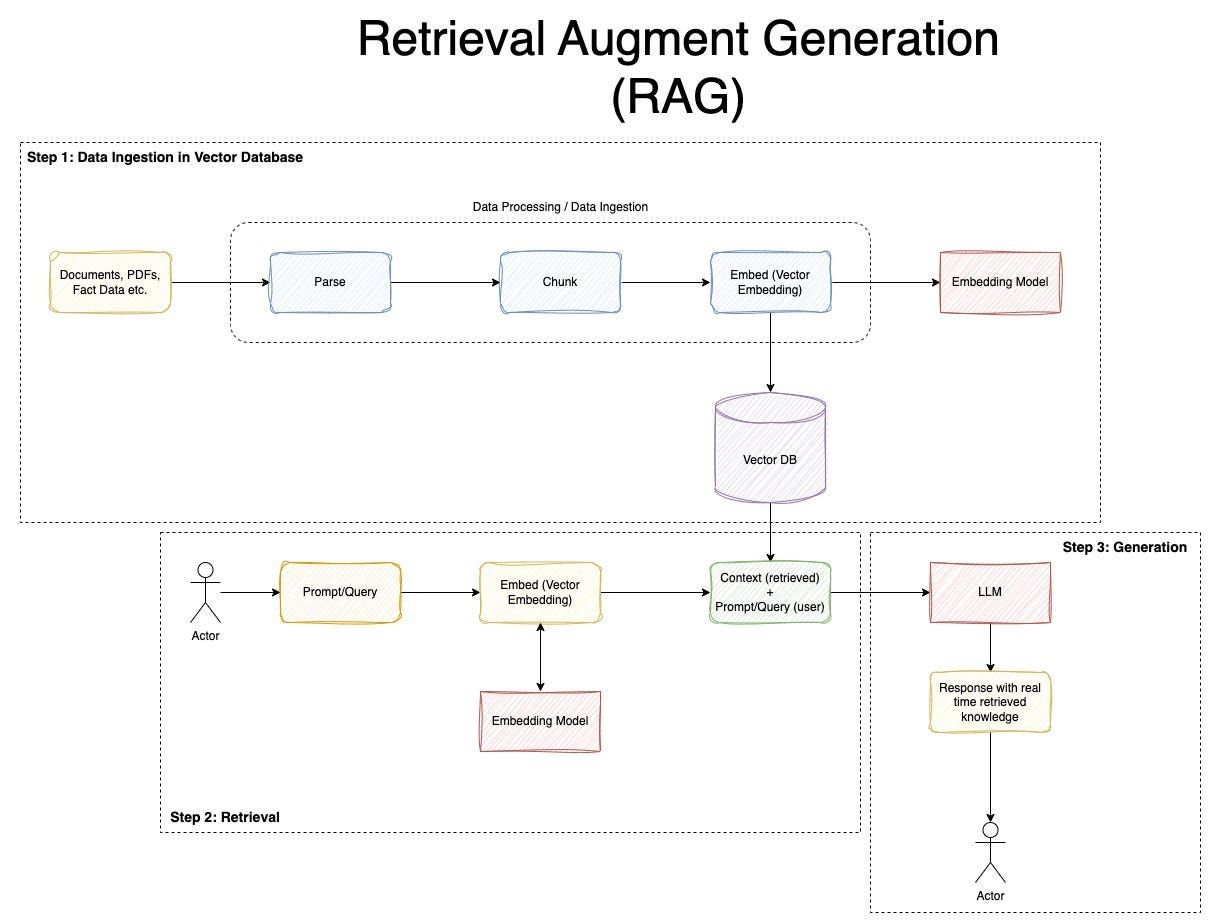

### Create Stuff Docment Chain

In [15]:
from langchain.chains.combine_documents import create_stuff_documents_chain

document_chain = create_stuff_documents_chain(llm, prompt)
document_chain

RunnableBinding(bound=RunnableBinding(bound=RunnableAssign(mapper={
  context: RunnableLambda(format_docs)
}), kwargs={}, config={'run_name': 'format_inputs'}, config_factories=[])
| ChatPromptTemplate(input_variables=['context', 'input'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'input'], input_types={}, partial_variables={}, template='\nAnswer the following question based only on the provided context. \nThink step by step before providing a detailed answer. \nI will tip you $1000 if the user finds the answer helpful. \n<context>\n{context}\n</context>\nQuestion: {input}'), additional_kwargs={})])
| OllamaLLM(model='llama3.2')
| StrOutputParser(), kwargs={}, config={'run_name': 'stuff_documents_chain'}, config_factories=[])

### Retrievers

In [18]:
"""
Retrievers: A retriever is an interface that returns documents given
 an unstructured query. It is more general than a vector store.
 A retriever does not need to be able to store documents, only to 
 return (or retrieve) them. Vector stores can be used as the backbone
 of a retriever, but there are other types of retrievers as well. 
 https://python.langchain.com/docs/modules/data_connection/retrievers/   
"""

retriever = db.as_retriever()
retriever

VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x10a056410>, search_kwargs={})

### Retrieval chain

In [19]:
"""
Retrieval chain: This chain takes in a user inquiry, which is then
passed to the retriever to fetch relevant documents. Those documents 
(and original inputs) are then passed to an LLM to generate a response
https://python.langchain.com/docs/modules/chains/
"""
from langchain.chains import create_retrieval_chain

retrieval_chain = create_retrieval_chain(retriever,document_chain)

In [20]:
response = retrieval_chain.invoke({"input":"Scaled Dot-Product Attention"})

In [21]:
response['answer']

'To answer this question based only on the provided context:\n\nThe Scaled Dot-Product Attention is an attention mechanism used in the Transformer model. It consists of two main components:\n\n1. The scaled dot-product attention function, which computes the weights on the values by taking the dot product of the query with all keys, dividing each by √dk, and applying a softmax function.\n2. The multi-head attention mechanism, which uses multiple parallel attention layers to jointly attend to information from different representation subspaces at different positions.\n\nThe scaled dot-product attention is compared to additive attention, which uses a feed-forward network with a single hidden layer to compute the compatibility function. While both mechanisms have similar theoretical complexity, the scaled dot-product attention is faster and more space-efficient in practice due to its use of highly optimized matrix multiplication code.\n\nIn contrast, multi-head attention allows the model t

In [22]:
print(response['answer'])

To answer this question based only on the provided context:

The Scaled Dot-Product Attention is an attention mechanism used in the Transformer model. It consists of two main components:

1. The scaled dot-product attention function, which computes the weights on the values by taking the dot product of the query with all keys, dividing each by √dk, and applying a softmax function.
2. The multi-head attention mechanism, which uses multiple parallel attention layers to jointly attend to information from different representation subspaces at different positions.

The scaled dot-product attention is compared to additive attention, which uses a feed-forward network with a single hidden layer to compute the compatibility function. While both mechanisms have similar theoretical complexity, the scaled dot-product attention is faster and more space-efficient in practice due to its use of highly optimized matrix multiplication code.

In contrast, multi-head attention allows the model to jointly 